In [233]:
# Data wrangling:
import pandas as pd

# Seleção e validação dos modelos:
from sklearn.model_selection import train_test_split

# Modelos:
from pmdarima.arima import auto_arima

# Deployment:
import pickle

In [234]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
rcParams['figure.figsize'] = 15, 6

## DataFrame:

In [235]:
path = r'../../data/dataset_CASTING_DB106.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    parse_dates=['VUF_DT'],
    index_col='VUF_DT',
    usecols=['VUF_DT', 'VUF_VLRLIQFINAL']
)

In [236]:
df

,VUF_VLRLIQFINAL
VUF_DT,
2023-05-10,152.00
2023-05-15,55.00
2023-06-22,45900.00
2023-05-05,51.00
2023-05-05,105.00
...,...
2022-05-24,6.98
2022-05-23,99.98
2022-05-23,160.00


## Código:

In [237]:
class Casting:
    def preenchendo_periodos_faltantes(self, series: pd.Series):
        start = series.index.min().to_timestamp()
        end = series.index.max().to_timestamp()
        todos_periodos = pd.date_range(start=start, end=end, freq='M').to_period("M")

        periodos_faltantes = todos_periodos.difference(series.index)

        # Preencha os períodos faltantes com 0
        for periodo in periodos_faltantes:
            series.at[periodo] = 0 #(series.loc[periodo-2:periodo-1]).median()

        # Ordene o índice
        series = series.sort_index()

        return series


if __name__ == '__main__':
    casting = Casting()

## Preparação dos dados:

### Agrupando por mês:

In [238]:
df = (
    df.groupby(
        (df.index).to_period("M")
    )['VUF_VLRLIQFINAL'].sum()
)

### Removendo o mês de outubro:

In [239]:
df = df.drop(df.index[-1])

### Preenchendo períodos faltantes:

In [240]:
df = casting.preenchendo_periodos_faltantes(series=df)

## Visualização:

### ACF:

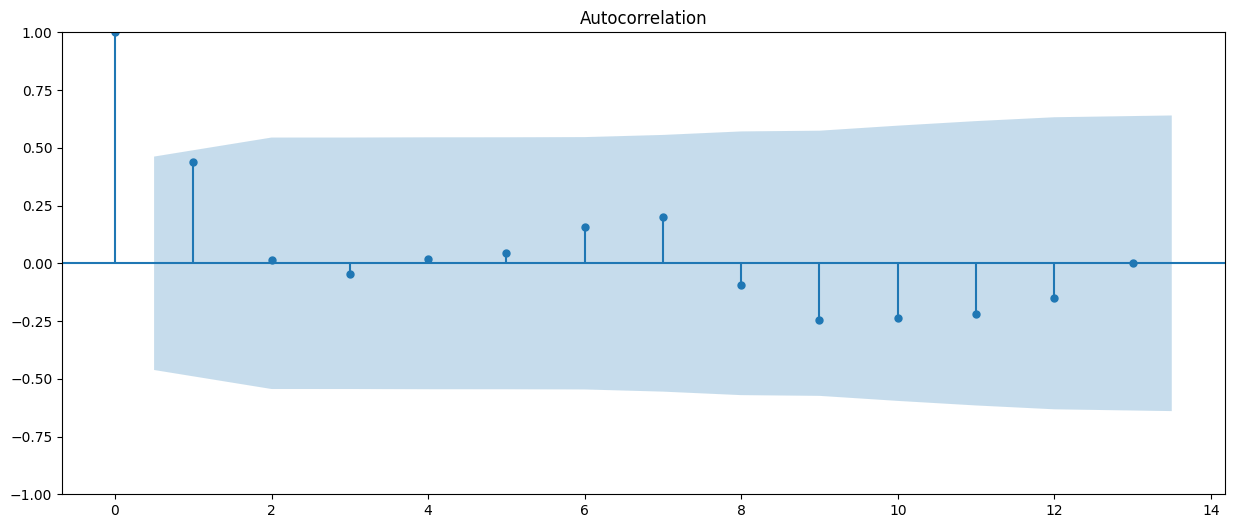

In [241]:
plot_acf(df)
plt.show()

### PACF:

In [242]:
# plot_pacf(series)
# plt.show()

## Modelo:

### Procurando Modelo:

In [243]:
model = auto_arima(
    df,
)

### Melhor Resultado:

In [244]:
print(model.aic())

474.47574585766006


In [245]:
print(model.aicc())

476.1900315719458


In [246]:
print(model.bic())

477.14686113134854


***Obs:*** *Quanto menor o valor melhor.*

### Train-test Split:

In [247]:
df.index

PeriodIndex(['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
             '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09'],
            dtype='period[M]', name='VUF_DT')

In [248]:
train = df.loc['2022-04-01':'2023-08-01']
test = df.loc['2023-09-01':]

### Treinando o modelo:

In [249]:
model.fit(train)

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

## Avaliação:

### Resíduo:

In [250]:
test - model.predict(n_periods=1)

VUF_DT
2023-09   -44171.069339
Freq: M, dtype: float64

In [251]:
model.predict(n_periods=1)

2023-09    46286.949339
Freq: M, dtype: float64

***Resíduo*** = *Valor Real - Valor Previsto*

### Deployment:

In [252]:
path = r'../../models/DB106_arima.pkl' 

with open(path, 'wb') as file:
    pickle.dump(model, file)